## Business use case:
+ An FMCG company entered into the instant noodles business two years back. Their higher management has noticed that there is a miss match in the demand and supply. Where the demand is high, supply is pretty low and where the demand is low, supply is pretty high. In both ways, it is an inventory cost loss to the company; hence, the higher management wants to optimize the supply quantity in every warehouse in the entire country.


### Goal & Objective: 
+ To build a model that will determine the optimum weight of the product to be shipped each time to the warehouse.
+ Also, to analyze the demand pattern in different pockets of the country so management can drive the advertisement campaign, particularly in those pockets.



In [1]:
#importing libraries
import numpy as np
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt
import os
import sys
%matplotlib inline

# Ignore Warnings
import warnings
warnings.filterwarnings("ignore")
warnings.warn("this will not show")

In [2]:
#!pip install termcolor
import colorama
from colorama import Fore, Style  # makes strings colored
from termcolor import colored
from termcolor import cprint

# Figure&Display options
plt.rcParams["figure.figsize"] = (16, 15)
pd.set_option('max_colwidth',200)
pd.set_option('display.max_rows', 1000)
pd.set_option('display.max_columns', 200)
# pd.set_option('display.float_format', lambda x: '%.2f' % x)

In [3]:
#!pip install cufflinks

In [4]:
# Importing plotly and cufflinks in offline mode
import cufflinks as cf
import plotly.offline
cf.go_offline()
cf.set_config_file(offline=True, world_readable=True)
import plotly.express as px
from plotly.subplots import make_subplots
import plotly.graph_objects as go

## DATA COLLECTION AND PREPROCESSING

### Data structure

In [5]:
fmcg_data = pd.read_csv("Data.csv")
fmcg_data.head()

,Ware_house_ID,WH_Manager_ID,Location_type,WH_capacity_size,zone,WH_regional_zone,num_refill_req_l3m,transport_issue_l1y,Competitor_in_mkt,retail_shop_num,wh_owner_type,distributor_num,flood_impacted,flood_proof,electric_supply,dist_from_hub,workers_num,wh_est_year,storage_issue_reported_l3m,temp_reg_mach,approved_wh_govt_certificate,wh_breakdown_l3m,govt_check_l3m,product_wg_ton
0,WH_100000,EID_50000,Urban,Small,West,Zone 6,3,1,2,4651,Rented,24,0,1,1,91,29.0,NaN,13,0,A,5,15,17115
1,WH_100001,EID_50001,Rural,Large,North,Zone 5,0,0,4,6217,Company Owned,47,0,0,1,210,31.0,NaN,4,0,A,3,17,5074
2,WH_100002,EID_50002,Rural,Mid,South,Zone 2,1,0,4,4306,Company Owned,64,0,0,0,161,37.0,NaN,17,0,A,6,22,23137
3,WH_100003,EID_50003,Rural,Mid,North,Zone 3,7,4,2,6000,Rented,50,0,0,0,103,21.0,NaN,17,1,A+,3,27,22115
4,WH_100004,EID_50004,Rural,Large,North,Zone 5,3,1,2,4740,Company Owned,42,1,0,1,112,25.0,2009.0,18,0,C,6,24,24071


In [6]:
df_dtypes_table = pd.DataFrame(fmcg_data.dtypes).reset_index()
df_dtypes_table.columns = ['Column Name', 'Data Type']
df_dtypes_table

,Column Name,Data Type
0,Ware_house_ID,object
1,WH_Manager_ID,object
2,Location_type,object
3,WH_capacity_size,object
4,zone,object
5,WH_regional_zone,object
6,num_refill_req_l3m,int64
7,transport_issue_l1y,int64
8,Competitor_in_mkt,int64
9,retail_shop_num,int64


### Data preparation and cleaning

In [7]:
def missing_values(df):
    missing_number = df.isnull().sum().sort_values(ascending=False)
    missing_percent = (df.isnull().sum()/df.shape[0]).sort_values(ascending=False)
    missing_values = pd.concat([missing_number, missing_percent], axis=1, keys=['Missing_Number', 'Missing_Percent'])
    return missing_values[missing_values['Missing_Number']>0]

In [8]:
def first_looking(df):
    print(colored("Shape:", attrs=['bold']), df.shape,'\n', 
          colored('*'*100, 'red', attrs=['bold']),
          colored("\nInfo:\n", attrs=['bold']), sep='')
    print(df.info(), '\n', 
          colored('*'*100, 'red', attrs=['bold']), sep='')
    print(colored("Number of Uniques:\n", attrs=['bold']), df.nunique(),'\n',
          colored('*'*100, 'red', attrs=['bold']), sep='')
    print(colored("Missing Values:\n", attrs=['bold']), missing_values(df),'\n', 
          colored('*'*100, 'red', attrs=['bold']), sep='')
    print(colored("All Columns:", attrs=['bold']), list(df.columns),'\n', 
          colored('*'*100, 'red', attrs=['bold']), sep='')

    df.columns= df.columns.str.lower().str.replace('&', '_').str.replace(' ', '_')
    print(colored("Columns after rename:", attrs=['bold']), list(df.columns),'\n',
          colored('*'*100, 'red', attrs=['bold']), sep='')
    print(colored("Descriptive Statistics \n", attrs=['bold']), df.describe().round(2),'\n',
          colored('*'*100, 'red', attrs=['bold']), sep='') # Gives a statstical breakdown of the data.
    print(colored("Descriptive Statistics (Categorical Columns) \n", attrs=['bold']), df.describe(include=object).T,'\n',
          colored('*'*100, 'red', attrs=['bold']), sep='') # Gives a statstical breakdown of the data.

In [9]:
# To view summary information about the columns

def first_look(df,col):
    print("column name    : ", col)
    print("per_of_nulls   : ", "%", round(df[col].isnull().sum()/df.shape[0]*100, 2))
    print("num_of_nulls   : ", df[col].isnull().sum())
    print("num_of_uniques : ", df[col].nunique())
    print("Value counts   : \n", df[col].value_counts(dropna = False)) 
    print(colored("-"*100, 'red',attrs=['bold']), sep="")

In [10]:
def multicolinearity_control(df):
    feature =[]
    collinear=[]
    for col in df.corr().columns:
        for i in df.corr().index:
            if (abs(df.corr()[col][i])> .75 and abs(df.corr()[col][i]) < 1):
                    feature.append(col)
                    collinear.append(i)
                    print(colored(f"Multicolinearity alert in between:{col} - {i}", 
                                  "red", attrs=['bold']), df.shape,'\n',
                                  colored('*'*100, 'red', attrs=['bold']), sep='')
    else:
        print("No Multicolinearity")

In [11]:
def duplicate_values(df):
    print(colored("Duplicate check...", attrs=['bold']), sep='')
    duplicate_values = df.duplicated(subset=None, keep='first').sum()
    if duplicate_values > 0:
        df.drop_duplicates(keep='first', inplace=True)
        print(duplicate_values, colored(" Duplicates were dropped!"),'\n',
              colored('*'*100, 'red', attrs=['bold']), sep='')
    else:
        print(colored("There are no duplicates"),'\n',
              colored('*'*100, 'red', attrs=['bold']), sep='')

In [12]:
def drop_columns(df, drop_columns):
    if drop_columns !=[]:
        df.drop(drop_columns, axis=1, inplace=True)
        print(drop_columns, 'were dropped')
    else:
        print(colored('We will now check the missing values and if necessary, the realted columns will be dropped!', attrs=['bold']),'\n',
              colored('*'*100, 'red', attrs=['bold']), sep='')

In [13]:
def drop_null(df, limit):
    print('Shape:', df.shape)
    for i in df.isnull().sum().index:
        if (df.isnull().sum()[i]/df.shape[0]*100)>limit:
            print(df.isnull().sum()[i], 'percent of', i ,'null and were dropped')
            df.drop(i, axis=1, inplace=True)
            print('new shape:', df.shape)       
    print(colored("New shape after missing value control:"),'\n', df.shape)

In [14]:
first_looking(fmcg_data)

Shape:(25000, 24)
****************************************************************************************************
Info:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25000 entries, 0 to 24999
Data columns (total 24 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Ware_house_ID                 25000 non-null  object 
 1   WH_Manager_ID                 25000 non-null  object 
 2   Location_type                 25000 non-null  object 
 3   WH_capacity_size              25000 non-null  object 
 4   zone                          25000 non-null  object 
 5   WH_regional_zone              25000 non-null  object 
 6   num_refill_req_l3m            25000 non-null  int64  
 7   transport_issue_l1y           25000 non-null  int64  
 8   Competitor_in_mkt             25000 non-null  int64  
 9   retail_shop_num               25000 non-null  int64  
 10  wh_owner_type                 25000 non-null  object

In [15]:
duplicate_values(fmcg_data)

Duplicate check...
There are no duplicates
****************************************************************************************************


### Checking for null values and dropping the columns with more than 30% null

<Figure size 500x500 with 0 Axes>

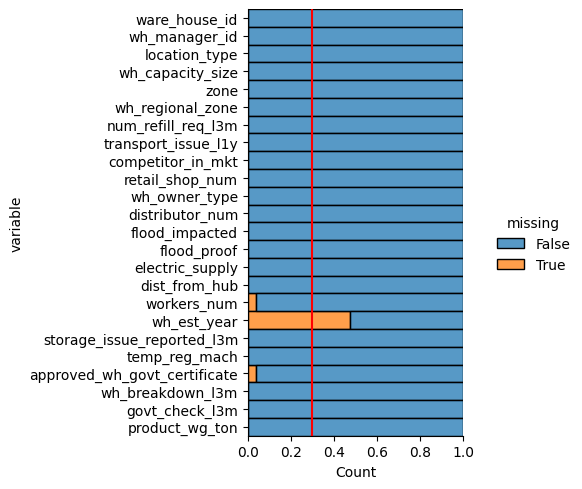

In [16]:
plt.figure(figsize = (5, 5))

sns.displot(
    data = fmcg_data.isnull().melt(value_name = "missing"),
    y = "variable",
    hue = "missing",
    multiple = "fill",
    height = 5)

plt.axvline(0.3, color = "r");

In [17]:
drop_null(fmcg_data,30)

Shape: (25000, 24)
11881 percent of wh_est_year null and were dropped
new shape: (25000, 23)
New shape after missing value control: 
 (25000, 23)


In [18]:
fmcg_data.corr()

,num_refill_req_l3m,transport_issue_l1y,competitor_in_mkt,retail_shop_num,distributor_num,flood_impacted,flood_proof,electric_supply,dist_from_hub,workers_num,storage_issue_reported_l3m,temp_reg_mach,wh_breakdown_l3m,govt_check_l3m,product_wg_ton
num_refill_req_l3m,1.000000,0.018549,0.002985,-0.001186,0.003995,-0.010548,-0.001123,-0.007959,0.000048,-0.013764,-0.006602,0.260928,0.000608,-0.003302,0.001415
transport_issue_l1y,0.018549,1.000000,-0.005826,-0.001826,0.008993,-0.009596,0.000022,-0.009299,0.014336,-0.009004,-0.144327,0.018207,0.012990,0.002190,-0.173992
competitor_in_mkt,0.002985,-0.005826,1.000000,-0.156943,-0.001492,0.009338,-0.003444,0.001759,0.008407,0.000050,0.009543,0.009524,0.012733,-0.043455,0.008884
retail_shop_num,-0.001186,-0.001826,-0.156943,1.000000,-0.000395,-0.003774,0.007223,-0.009207,0.000429,-0.005406,-0.006632,-0.001273,-0.008420,0.045749,-0.006615
distributor_num,0.003995,0.008993,-0.001492,-0.000395,1.000000,0.004611,-0.003409,0.000454,-0.011838,-0.014682,0.003396,0.002827,0.004286,-0.007934,0.004999
flood_impacted,-0.010548,-0.009596,0.009338,-0.003774,0.004611,1.000000,0.107015,0.164815,0.000749,0.168425,-0.003157,-0.008554,-0.001744,0.000587,-0.002299
flood_proof,-0.001123,0.000022,-0.003444,0.007223,-0.003409,0.107015,1.000000,0.114811,-0.005315,0.041228,-0.002712,0.005636,-0.005151,-0.003600,-0.000441
electric_supply,-0.007959,-0.009299,0.001759,-0.009207,0.000454,0.164815,0.114811,1.000000,-0.002701,0.339990,-0.001877,-0.007600,-0.010371,-0.005234,-0.002160
dist_from_hub,0.000048,0.014336,0.008407,0.000429,-0.011838,0.000749,-0.005315,-0.002701,1.000000,-0.018565,-0.005726,0.000902,-0.000906,-0.000531,-0.005017
workers_num,-0.013764,-0.009004,0.000050,-0.005406,-0.014682,0.168425,0.041228,0.339990,-0.018565,1.000000,-0.008673,0.001419,-0.017877,-0.003137,-0.008346


In [19]:
multicolinearity_control(fmcg_data)

Multicolinearity alert in between:storage_issue_reported_l3m - product_wg_ton(25000, 23)
****************************************************************************************************
Multicolinearity alert in between:product_wg_ton - storage_issue_reported_l3m(25000, 23)
****************************************************************************************************
No Multicolinearity


In [20]:
first_look(fmcg_data,"workers_num")

column name    :  workers_num
per_of_nulls   :  % 3.96
num_of_nulls   :  990
num_of_uniques :  60
Value counts   : 
 28.0    1491
27.0    1447
29.0    1402
26.0    1290
25.0    1268
24.0    1228
30.0    1202
31.0    1132
23.0    1077
32.0    1077
NaN      990
22.0     959
33.0     916
21.0     826
34.0     796
20.0     783
36.0     671
35.0     670
19.0     590
18.0     559
37.0     506
17.0     445
39.0     419
38.0     417
40.0     381
16.0     328
42.0     298
41.0     240
43.0     212
44.0     204
45.0     175
15.0     155
14.0     104
46.0      91
50.0      73
48.0      71
49.0      65
55.0      50
47.0      47
53.0      45
56.0      40
54.0      39
51.0      30
52.0      29
57.0      24
13.0      24
58.0      20
12.0      15
61.0      14
60.0      10
67.0       5
65.0       5
72.0       5
64.0       5
11.0       5
92.0       5
78.0       5
10.0       5
98.0       5
62.0       5
63.0       5
Name: workers_num, dtype: int64
----------------------------------------------------------

In [21]:
first_look(fmcg_data,"approved_wh_govt_certificate")

column name    :  approved_wh_govt_certificate
per_of_nulls   :  % 3.63
num_of_nulls   :  908
num_of_uniques :  5
Value counts   : 
 C      5501
B+     4917
B      4812
A      4671
A+     4191
NaN     908
Name: approved_wh_govt_certificate, dtype: int64
----------------------------------------------------------------------------------------------------


In [22]:
first_look(fmcg_data,"zone")

column name    :  zone
per_of_nulls   :  % 0.0
num_of_nulls   :  0
num_of_uniques :  4
Value counts   : 
 North    10278
West      7931
South     6362
East       429
Name: zone, dtype: int64
----------------------------------------------------------------------------------------------------


In [23]:
first_look(fmcg_data, "wh_regional_zone")

column name    :  wh_regional_zone
per_of_nulls   :  % 0.0
num_of_nulls   :  0
num_of_uniques :  6
Value counts   : 
 Zone 6    8339
Zone 5    4587
Zone 4    4176
Zone 2    2963
Zone 3    2881
Zone 1    2054
Name: wh_regional_zone, dtype: int64
----------------------------------------------------------------------------------------------------


In [24]:
#sum(fmcg_data["wh_regional_zone"].value_counts().values)

## DATA EXPLORATION AND VISUALIZATION

### To check the number of warehouses in each zone

In [25]:
region_zone_df = fmcg_data.groupby(["zone","wh_regional_zone"],as_index=False)["ware_house_id"].count()
region_zone_df.columns = ["Zone", "WH Regional Zone", "Count"]
region_zone_df["Total warehouses"] = region_zone_df.groupby("WH Regional Zone")["Count"].transform("sum")
region_zone_df["Percentage"] = round((region_zone_df["Count"]/region_zone_df["Total warehouses"])*100,2)
region_zone_df.sort_values(by="Percentage", ascending=False, inplace=True)

In [26]:
region_zone_pivot_df=region_zone_df.pivot_table(values="Percentage" , index=["Zone"], columns=["WH Regional Zone"])
region_zone_pivot_df.style.highlight_max(color = 'lightgreen').highlight_min(color = 'coral').highlight_null(null_color='yellow')

WH Regional Zone,Zone 1,Zone 2,Zone 3,Zone 4,Zone 5,Zone 6
Zone,,,,,,
East,2.090000,nan,3.890000,3.400000,1.610000,0.700000
North,40.940000,28.820000,33.360000,28.400000,41.790000,54.190000
South,33.110000,48.730000,30.720000,21.120000,24.130000,16.360000
West,23.860000,22.440000,32.040000,47.080000,32.460000,28.760000


In [27]:
zone_df=fmcg_data.groupby(["zone","wh_capacity_size","wh_regional_zone"],as_index=False)["wh_regional_zone"].count()
zone_df.rename(columns={"zone":"Zone", "wh_capacity_size":"WareHouse Size", "wh_regional_zone":"No of WareHouses"},inplace=True)

In [28]:
nzone_df = fmcg_data.groupby(["zone","wh_regional_zone"],as_index=False)["ware_house_id"].count()
nzone_df.sort_values("ware_house_id", ascending=False)

,zone,wh_regional_zone,ware_house_id
10,North,Zone 6,4519
22,West,Zone 6,2398
20,West,Zone 4,1966
9,North,Zone 5,1917
21,West,Zone 5,1489
12,South,Zone 2,1444
16,South,Zone 6,1364
8,North,Zone 4,1186
15,South,Zone 5,1107
7,North,Zone 3,961


In [29]:
zone_df["Total Warehouses"] = zone_df.groupby(["WareHouse Size"])["No of WareHouses"].transform('sum')
zone_df["percentage [%]"] = round((zone_df["No of WareHouses"]/zone_df["Total Warehouses"])*100,2)
zone_df.sort_values(by="percentage [%]", ascending=False, inplace=True)

In [30]:
zone_df.pivot_table(index="Zone", columns="WareHouse Size", values="percentage [%]").style.highlight_max(color = 'lightgreen').highlight_min(color = 'coral').highlight_null(null_color='yellow')

WareHouse Size,Large,Mid,Small
Zone,,,
East,0.730000,1.270000,1.050000
North,26.995000,9.983333,18.570000
South,7.945000,10.680000,15.960000
West,14.700000,11.823333,14.410000


In [31]:
fig = px.bar(zone_df, x=zone_df["Zone"], y=zone_df["No of WareHouses"], color=zone_df["WareHouse Size"], title="No of WareHouses in each Zone according to size", color_discrete_sequence=["darkslateblue", "deepskyblue", "gainsboro"])
fig.show()

In North Zone maximum number of warehouses are present followed by West and South Zones and in East Zone it is the least. 

Also most of the warehouses are Mid and Large size.

### To check the number of warehouses in each type of location

In [32]:
loc_df=fmcg_data.groupby(["location_type","wh_capacity_size"],as_index=False)["wh_regional_zone"].count()

In [33]:
loc_df.columns=["Location Type","WareHouse size", "# of WareHouses"]

In [34]:
fig = px.bar(loc_df, x="Location Type", y="# of WareHouses", color="WareHouse size", title="No of WareHouses in different location",
            color_discrete_sequence=["green","orange", "grey" ])
fig.show()

Maximum number of warehouses are present in Rural areas.

### Why Rural type has more number of warehouses?


In [35]:
retail_df = fmcg_data.groupby("location_type", as_index=False)["retail_shop_num"].sum()
retail_df.columns= ["Type of Location", "# of retail shop" ]
fig = px.pie(retail_df, 
             values  = "# of retail shop", 
             names = "Type of Location", 
             color="Type of Location",
             title = 'Number of retail shops', color_discrete_map={"Rural":"darkorange", "Urban":'dodgerblue'})

fig.show()

There are more retail shops in the rural location as compared to urban area. So, number of warehouses are more in rural areas

## Number of warehouses refilled in last 3 months

In [36]:
refill_df=fmcg_data.groupby(["wh_regional_zone","zone"],as_index=False)["num_refill_req_l3m"].count()
refill_df.columns=["WareHouse Zone","Zone", "# of WareHouses refilled in last 3 months"]
refill_df["Total warehouses"]=refill_df.groupby("WareHouse Zone")["# of WareHouses refilled in last 3 months"].transform("sum")
refill_df["Percentage"] = round((refill_df["# of WareHouses refilled in last 3 months"]/refill_df["Total warehouses"])*100,2)

In [37]:
refill_df.pivot_table(index="Zone", columns="WareHouse Zone", values="Percentage").style.highlight_max(color = 'lightgreen').highlight_min(color = 'coral').highlight_null(null_color='yellow')

WareHouse Zone,Zone 1,Zone 2,Zone 3,Zone 4,Zone 5,Zone 6
Zone,,,,,,
East,2.090000,nan,3.890000,3.400000,1.610000,0.700000
North,40.940000,28.820000,33.360000,28.400000,41.790000,54.190000
South,33.110000,48.730000,30.720000,21.120000,24.130000,16.360000
West,23.860000,22.440000,32.040000,47.080000,32.460000,28.760000


In [38]:
fig = px.funnel(refill_df, x="WareHouse Zone", y="# of WareHouses refilled in last 3 months", color="Zone", title="No of WareHouses refilled in different zones in last 3 months",
               color_discrete_sequence = ['red', 'blue', 'orange', 'green'])
fig.show()

Zone 6 in North has maximum number of refillings and Zone 1 in west has less number of refillings

### Number of retail shops in each zone

In [39]:
retail_zone_df = fmcg_data.groupby(["zone","wh_regional_zone" ], as_index=False)[["retail_shop_num"]].count()
retail_zone_df.columns = ["Zone", "WareHouse Zone","# of retail shop"]
fig = px.treemap(retail_zone_df, path=["Zone"], values="# of retail shop", width=950, height=600)
fig.update_layout(title_text="# of retail shop",
                  title_x=0.5, title_font=dict(size=20)
                  )
fig.update_layout(margin = dict(t=50, l=25, r=25, b=25))
fig.show()

In [40]:
retail_zone_df = fmcg_data.groupby(["zone","wh_regional_zone" ], as_index=False)[["retail_shop_num"]].count()
retail_zone_df.columns = ["Zone", "WareHouse Zone","# of retail shop"]
retail_zone_df["Total retail shops"] = retail_zone_df.groupby("WareHouse Zone")["# of retail shop"].transform("sum")
retail_zone_df["Percentage"] = round((retail_zone_df["# of retail shop"]/retail_zone_df["Total retail shops"])*100,2)

In [41]:
retail_zone_df.pivot_table(index="Zone", columns="WareHouse Zone", values = "Percentage").style.highlight_max(color = 'lightgreen').highlight_min(color = 'coral').highlight_null(null_color='yellow')

WareHouse Zone,Zone 1,Zone 2,Zone 3,Zone 4,Zone 5,Zone 6
Zone,,,,,,
East,2.090000,nan,3.890000,3.400000,1.610000,0.700000
North,40.940000,28.820000,33.360000,28.400000,41.790000,54.190000
South,33.110000,48.730000,30.720000,21.120000,24.130000,16.360000
West,23.860000,22.440000,32.040000,47.080000,32.460000,28.760000


In [42]:
px.bar(retail_zone_df, x="Zone", y="# of retail shop", color="WareHouse Zone", title="No of retail shops under each zone")

All the above plots indicates that zones with maximum number of retail shops has more number of warehouses inturn has more refillings in last 3 months. 

For example Zone 6 of North zone has maximum number of retail shops which concludes that it has more number of warehouses and maximum refillings in last 3 months and so on

### Product weight shipped to each zone

In [43]:
weight_df = fmcg_data.groupby(["zone", "wh_regional_zone"], as_index=False)["product_wg_ton"].sum().sort_values(by="product_wg_ton", ascending=False)
weight_df.columns=["Zone", "Regional Zone", "Product Weight (Ton)"]
px.bar(data_frame=weight_df, x="Zone", y="Product Weight (Ton)", color="Regional Zone",title="Product weight shipped to each zone")

In [44]:
weight_df["Total weight"] = weight_df.groupby("Regional Zone")["Product Weight (Ton)"].transform("sum")
weight_df["percentage"] = round(weight_df["Product Weight (Ton)"]/weight_df["Total weight"]*100,2)
weight_df.pivot_table(index="Zone", columns="Regional Zone", values="percentage").style.highlight_max(color = 'lightgreen').highlight_min(color = 'coral').highlight_null(null_color='yellow')

Regional Zone,Zone 1,Zone 2,Zone 3,Zone 4,Zone 5,Zone 6
Zone,,,,,,
East,1.950000,nan,3.990000,3.570000,1.750000,0.690000
North,41.350000,28.490000,33.710000,28.350000,42.460000,54.360000
South,32.880000,48.760000,29.720000,20.770000,23.870000,16.390000
West,23.820000,22.750000,32.580000,47.310000,31.920000,28.560000


In [45]:
weight_df

,Zone,Regional Zone,Product Weight (Ton),Total weight,percentage
10,North,Zone 6,100249991,184421651,54.36
22,West,Zone 6,52661774,184421651,28.56
20,West,Zone 4,43804669,92596029,47.31
9,North,Zone 5,42893115,101017613,42.46
12,South,Zone 2,32467899,66580768,48.76
21,West,Zone 5,32242727,101017613,31.92
16,South,Zone 6,30235650,184421651,16.39
8,North,Zone 4,26254519,92596029,28.35
15,South,Zone 5,24113697,101017613,23.87
7,North,Zone 3,21335735,63290230,33.71


### Number of Competitors in Market

In [46]:
comp_df = fmcg_data.groupby(["zone","wh_regional_zone" ], as_index=False)["competitor_in_mkt"].sum().sort_values(by="competitor_in_mkt", ascending=False)
comp_df.columns= ["Zone", "Regional Zone", "# Competitors in market"]
px.bar(data_frame=comp_df, x="Zone", y="# Competitors in market", color="Regional Zone", title="Number of Competitors in Market")

In [47]:
comp_df["Total weight"] = comp_df.groupby("Regional Zone")["# Competitors in market"].transform("sum")
comp_df["percentage"] = round(comp_df["# Competitors in market"]/comp_df["Total weight"]*100,2)
comp_df.pivot_table(index="Zone", columns="Regional Zone", values="percentage").style.highlight_max(color = 'lightgreen').highlight_min(color = 'coral').highlight_null(null_color='yellow')

Regional Zone,Zone 1,Zone 2,Zone 3,Zone 4,Zone 5,Zone 6
Zone,,,,,,
East,3.310000,nan,6.110000,5.900000,2.680000,1.160000
North,40.480000,29.700000,31.440000,26.130000,40.350000,51.790000
South,26.890000,43.310000,24.280000,16.200000,19.680000,13.130000
West,29.320000,26.990000,38.170000,51.770000,37.300000,33.920000


Based on the competitors we come into certain conclusions in zones such as North zone 6:

**Differentiate your product**: Identify what makes your instant noodles unique and highlight those features that set you apart from your competitors. For example, you could offer a wider variety of flavors or emphasize that your noodles are made with healthier ingredients.

**Focus on quality**: Ensure that your product is of high quality and consistently meets customer expectations. This will help build trust with your customers and keep them coming back.

**Offer competitive pricing**: Pricing is an important factor in the instant noodles market. Research your competitors' prices and adjust your pricing strategy accordingly.

**Invest in marketing**: Effective marketing is crucial to help you get noticed in a crowded market. Invest in targeted advertising, social media marketing, and other promotional activities to reach your target audience specially in zone 6 of north warehouses

**Build strong distribution channels**: Ensure that your product is widely available by building strong distribution channels. This can include partnerships with retailers, online marketplaces, or direct-to-consumer sales.


### Number of distributors  in each zone

In [48]:
dist_df = fmcg_data.groupby(["zone","wh_regional_zone"],as_index=False)["distributor_num"].sum().sort_values(by="distributor_num", ascending = False)
dist_df

,zone,wh_regional_zone,distributor_num
10,North,Zone 6,190695
22,West,Zone 6,101613
20,West,Zone 4,83464
9,North,Zone 5,82251
21,West,Zone 5,63376
12,South,Zone 2,60376
16,South,Zone 6,58348
8,North,Zone 4,50621
15,South,Zone 5,46605
7,North,Zone 3,40228


In [49]:
dist_df["Total weight"] = dist_df.groupby("wh_regional_zone")["distributor_num"].transform("sum")
dist_df["percentage"] = round(dist_df["distributor_num"]/dist_df["Total weight"]*100,2)
dist_df.pivot_table(index="zone", columns="wh_regional_zone", values="percentage").style.highlight_max(color = 'lightgreen').highlight_min(color = 'coral').highlight_null(null_color='yellow')

wh_regional_zone,Zone 1,Zone 2,Zone 3,Zone 4,Zone 5,Zone 6
zone,,,,,,
East,2.210000,nan,3.960000,3.180000,1.560000,0.650000
North,41.080000,29.000000,32.840000,28.520000,42.120000,54.030000
South,32.760000,48.070000,30.740000,21.270000,23.870000,16.530000
West,23.950000,22.930000,32.450000,47.030000,32.450000,28.790000


## Problems faced in warehouse

### Transport issues in different zones

In [50]:
first_look(fmcg_data, "transport_issue_l1y")

column name    :  transport_issue_l1y
per_of_nulls   :  % 0.0
num_of_nulls   :  0
num_of_uniques :  6
Value counts   : 
 0    15215
1     4644
2     2198
3     1818
4      777
5      348
Name: transport_issue_l1y, dtype: int64
----------------------------------------------------------------------------------------------------


In [51]:
transport_issue_df = fmcg_data.groupby(["zone", "wh_regional_zone"], as_index=False)["transport_issue_l1y"].sum().sort_values(by="transport_issue_l1y", ascending=False)
transport_issue_df["total issues"] =  transport_issue_df.groupby("wh_regional_zone")["transport_issue_l1y"].transform("sum")
transport_issue_df["percentage"] = round(transport_issue_df["transport_issue_l1y"]/transport_issue_df["total issues"]*100,2)

In [52]:
transport_issue_df.pivot_table(index="zone", columns="wh_regional_zone", values = "percentage").style.highlight_max(color = 'lightgreen').highlight_min(color = 'coral').highlight_null(null_color='yellow')
transport_issue_df.sort_values("transport_issue_l1y", ascending=False)

,zone,wh_regional_zone,transport_issue_l1y,total issues,percentage
10,North,Zone 6,3446,6429,53.60
22,West,Zone 6,1819,6429,28.29
9,North,Zone 5,1539,3499,43.98
20,West,Zone 4,1530,3316,46.14
21,West,Zone 5,1134,3499,32.41
16,South,Zone 6,1120,6429,17.42
12,South,Zone 2,1061,2192,48.40
8,North,Zone 4,962,3316,29.01
15,South,Zone 5,775,3499,22.15
7,North,Zone 3,737,2269,32.48


Transport issue may be one of the reason that certain demands are not met in certain region. For example North of Zone 6 has more number of retail shops and more demand for the product. Also it has maximum transport issues in last 1 year. If there are transport issues, required number of products cannot be shipped to the warehouse which might cut of the supply which leads to the demand supply imbalance.


To mitigate the impact of transport issues on the supply chain, companies can adopt various strategies such as improving their transportation infrastructure, diversifying their transportation options, and investing in technology that helps optimize their logistics operations. By doing so, they can ensure that products are delivered to their customers in a timely and cost-effective manner, and avoid demand-supply imbalances that can hurt their bottom line.

In [53]:
first_look(fmcg_data,"flood_impacted")

column name    :  flood_impacted
per_of_nulls   :  % 0.0
num_of_nulls   :  0
num_of_uniques :  2
Value counts   : 
 0    22546
1     2454
Name: flood_impacted, dtype: int64
----------------------------------------------------------------------------------------------------


In [54]:
floodImp_df = fmcg_data.groupby(["zone","wh_regional_zone"],as_index=False)["flood_impacted"].sum().sort_values(by="flood_impacted", ascending = False)

In [55]:
floodProof_df = fmcg_data.groupby(["zone","wh_regional_zone"],as_index=False)["flood_proof"].sum().sort_values(by="flood_proof", ascending = False)

In [56]:
storage_df = fmcg_data.groupby(["zone","wh_regional_zone"],as_index=False)["storage_issue_reported_l3m"].sum().sort_values(by="storage_issue_reported_l3m", ascending = False)

In [57]:
breakdown_df = fmcg_data.groupby(["zone","wh_regional_zone"],as_index=False)["wh_breakdown_l3m"].sum().sort_values(by="wh_breakdown_l3m", ascending = False)

In [58]:
elec_supply_df = fmcg_data[fmcg_data["electric_supply"]==0]
elec_prob_df=elec_supply_df.groupby(["zone", "wh_regional_zone"], as_index=False)["ware_house_id"].count().sort_values(by="ware_house_id", ascending=False)

In [59]:
temp_df = fmcg_data[fmcg_data["temp_reg_mach"]==0]
temp_prob_df = temp_df.groupby(["zone", "wh_regional_zone"], as_index=False)["temp_reg_mach"].count().sort_values(by="temp_reg_mach", ascending=False)

In [60]:
govt_certi_df = fmcg_data[fmcg_data["approved_wh_govt_certificate"].isna()]
govt_certi_df.groupby(["zone", "wh_regional_zone"], as_index=False)["govt_check_l3m"].count().sort_values(by="govt_check_l3m", ascending = False)

,zone,wh_regional_zone,govt_check_l3m
10,North,Zone 6,165
22,West,Zone 6,75
9,North,Zone 5,68
20,West,Zone 4,61
21,West,Zone 5,60
16,South,Zone 6,58
8,North,Zone 4,56
12,South,Zone 2,48
13,South,Zone 3,41
6,North,Zone 2,41


In [61]:
govt_check_df=fmcg_data.groupby(["zone", "wh_regional_zone"], as_index=False)["govt_check_l3m"].count().sort_values(by="govt_check_l3m", ascending = False)

<Figure size 1000x1000 with 0 Axes>

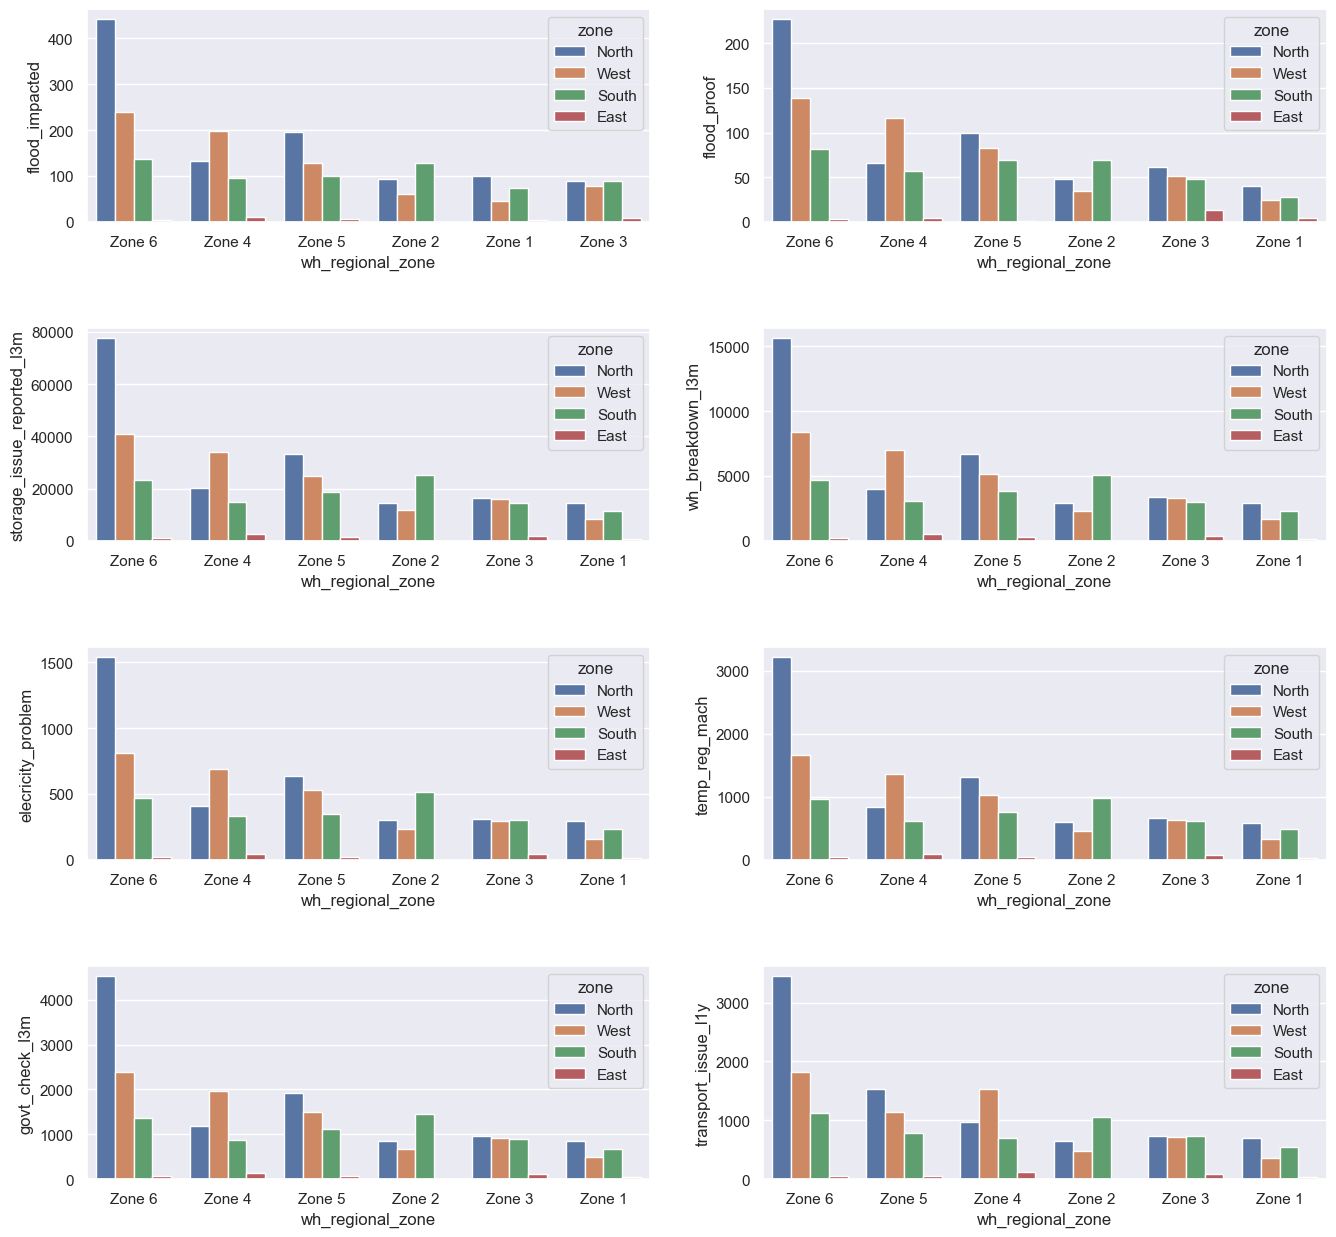

In [62]:
sns.set()
plt.figure(figsize=(10,10))
#define plotting region (2 rows, 2 columns)
fig, axes = plt.subplots(4, 2)

#create boxplot in each subplot
sns.barplot(data=floodImp_df, x='wh_regional_zone', y='flood_impacted', ax=axes[0,0], hue = "zone", )
sns.barplot(data=floodProof_df, x='wh_regional_zone', y="flood_proof", ax=axes[0,1], hue = "zone")
sns.barplot(data=storage_df, x='wh_regional_zone', y="storage_issue_reported_l3m", ax=axes[1,0], hue = "zone")
sns.barplot(data=breakdown_df, x='wh_regional_zone', y="wh_breakdown_l3m", ax=axes[1,1], hue = "zone")
ax=sns.barplot(data=elec_prob_df, x='wh_regional_zone', y="ware_house_id", ax=axes[2,0], hue = "zone")
ax.set_ylabel("elecricity_problem")
sns.barplot(data=temp_prob_df, x='wh_regional_zone', y="temp_reg_mach", ax=axes[2,1], hue = "zone")
sns.barplot(data=govt_check_df, x='wh_regional_zone', y="govt_check_l3m", ax=axes[3,0], hue = "zone")
sns.barplot(data=transport_issue_df, x='wh_regional_zone', y="transport_issue_l1y", ax=axes[3,1], hue = "zone");


fig.subplots_adjust(hspace=0.5,bottom=.1)

Problems like floods, storage issue, WH breakdown, electricty issue, temperature regulator issue, will have a significant impact on businesses, and it's important to address them as soon as possible in order to minimize any negative consequences.

Overall, it's important for businesses to have contingency plans in place to address these issues and minimize their impact. This may involve investing in flood prevention measures, implementing proper inventory management systems, and conducting regular maintenance and repairs on warehouse equipment. Additionally, it's important for businesses to have clear communication with customers and supply chain partners to mitigate any disruptions caused by these issues.

Also,  Number of time government Officers have been visited the warehouse to check the quality and expire of stored food in last 3 months may be because of complaints recieved from the dissatisfied customers which may be the cause for less demand of the product even though supply is high.


In [63]:
first_look(fmcg_data,'dist_from_hub')

column name    :  dist_from_hub
per_of_nulls   :  % 0.0
num_of_nulls   :  0
num_of_uniques :  217
Value counts   : 
 239    144
84     142
209    140
258    140
204    140
242    138
145    138
256    137
186    136
108    135
173    134
205    133
227    133
180    131
134    131
94     131
271    130
132    130
211    130
131    130
270    129
174    128
63     128
99     127
107    127
169    126
126    126
57     126
127    126
158    126
101    126
269    125
65     125
237    124
198    124
96     124
115    124
106    124
210    124
245    124
181    123
69     123
110    123
182    123
267    123
149    123
86     123
244    122
135    122
98     122
58     122
151    122
257    121
250    121
241    121
268    121
123    121
254    121
232    120
175    120
248    120
208    120
165    120
75     120
133    120
67     120
77     120
185    120
188    120
190    120
154    120
117    119
216    119
223    119
89     119
261    119
219    119
156    119
114    119
100    118
167

### Distance and refills

In [64]:
fmcg_data["dist_from_hub"].describe()

count    25000.000000
mean       163.537320
std         62.718609
min         55.000000
25%        109.000000
50%        164.000000
75%        218.000000
max        271.000000
Name: dist_from_hub, dtype: float64

<Axes: xlabel='dist_from_hub', ylabel='Count'>

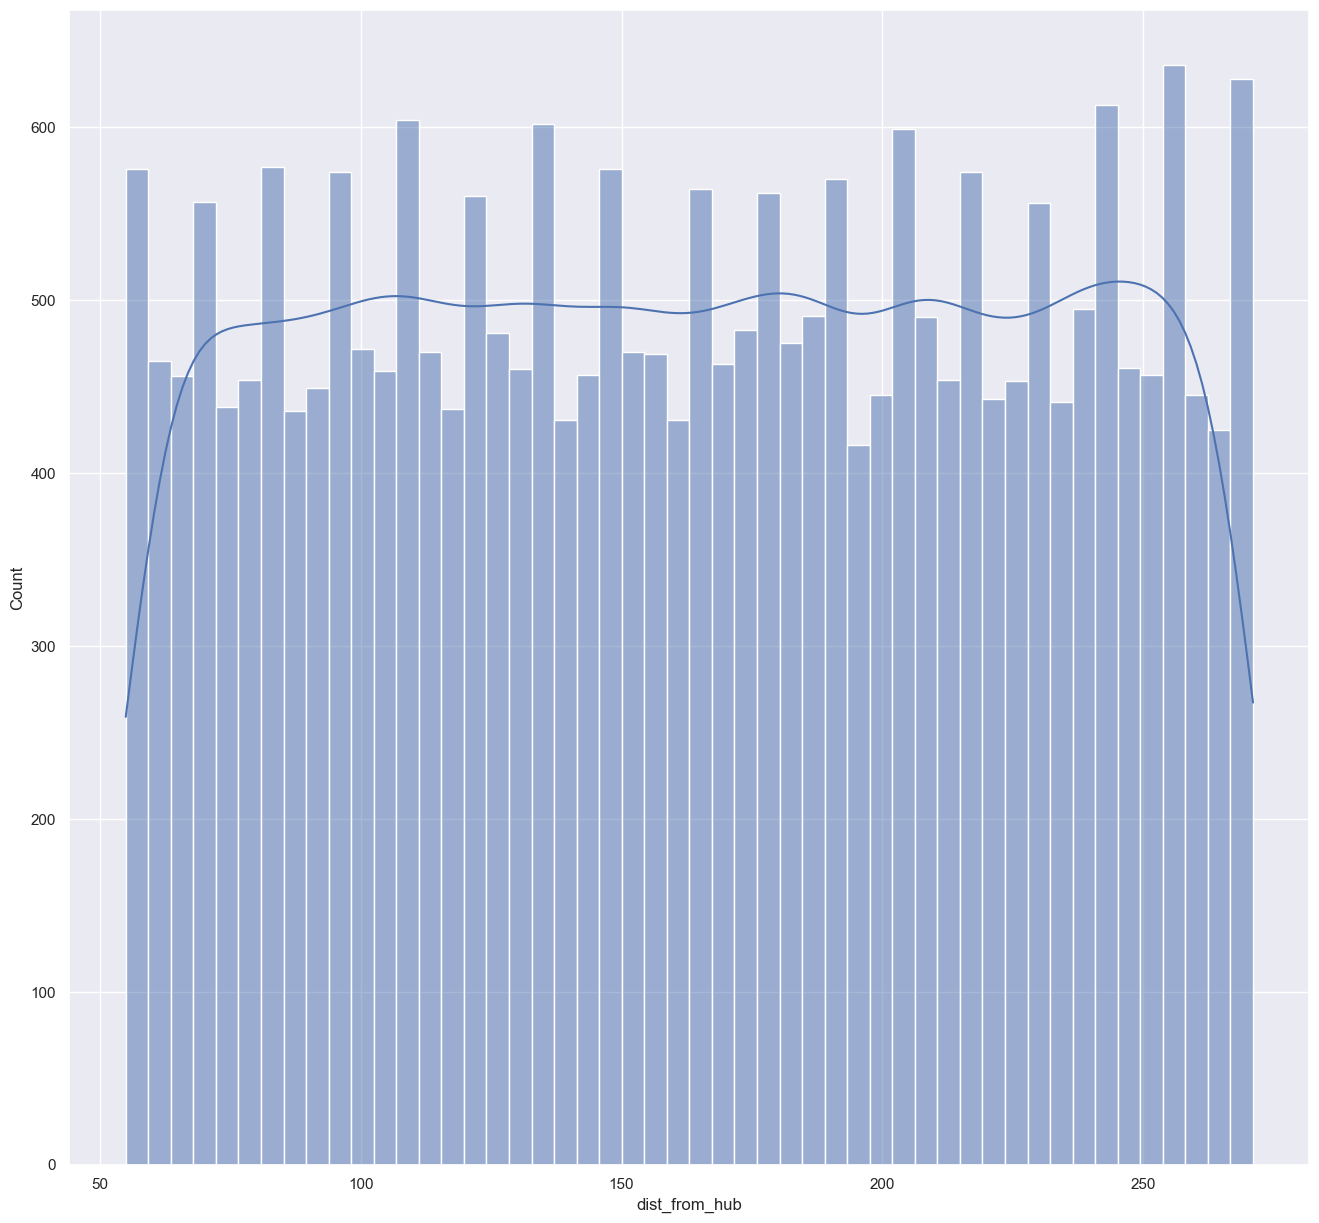

In [65]:
sns.histplot(fmcg_data["dist_from_hub"], bins=50, kde=True)

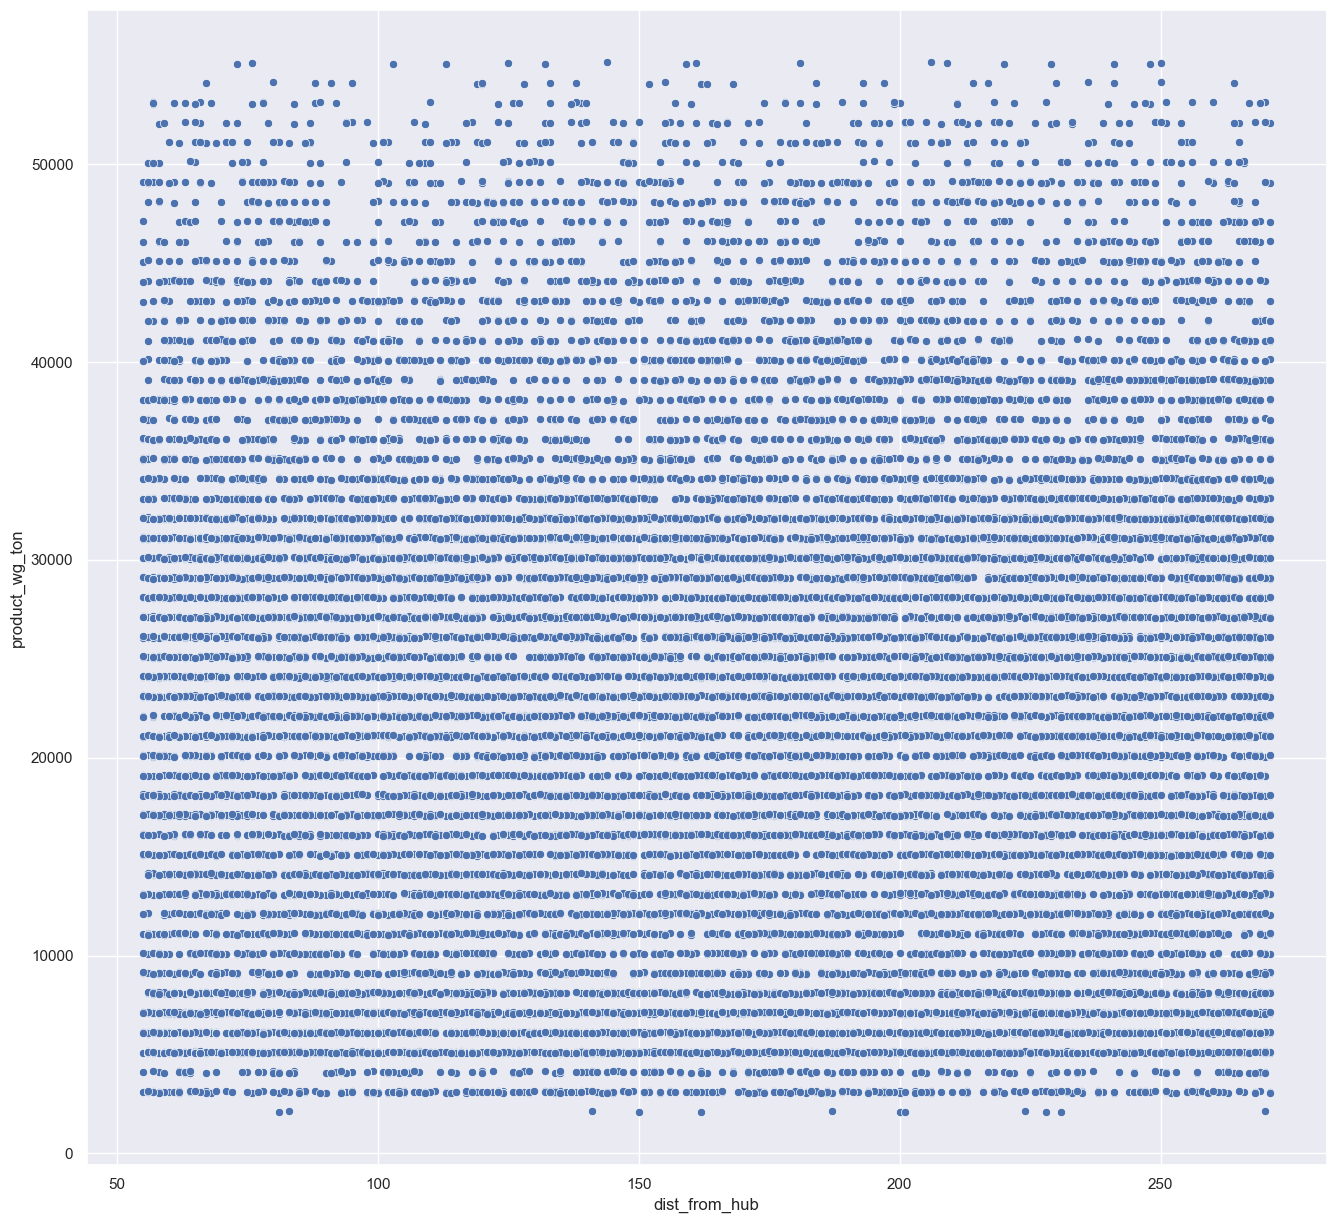

In [66]:
sns.scatterplot(x="dist_from_hub", y="product_wg_ton", data=fmcg_data, palette="");

In [67]:
def distance(x):
    if x<=90:
        return "short"
    elif x<=180:
        return "medium"
    else:
        return "long"     

In [68]:
fmcg_data["Distance Category"]=fmcg_data.dist_from_hub.apply(distance)

In [69]:
dis_refil_df=fmcg_data.groupby(["Distance Category","wh_regional_zone","wh_capacity_size", "zone"], as_index=False)["num_refill_req_l3m"].sum()

In [70]:
dis_refil_df.sort_values(by = "num_refill_req_l3m", ascending=False)

,Distance Category,wh_regional_zone,wh_capacity_size,zone,num_refill_req_l3m
45,medium,Zone 6,Large,North,6189
19,long,Zone 6,Large,North,6130
14,long,Zone 4,Mid,West,3490
40,medium,Zone 4,Mid,West,3465
16,long,Zone 5,Large,North,3270
42,medium,Zone 5,Large,North,3259
21,long,Zone 6,Large,West,2742
18,long,Zone 5,Large,West,2628
5,long,Zone 2,Mid,South,2582
47,medium,Zone 6,Large,West,2543


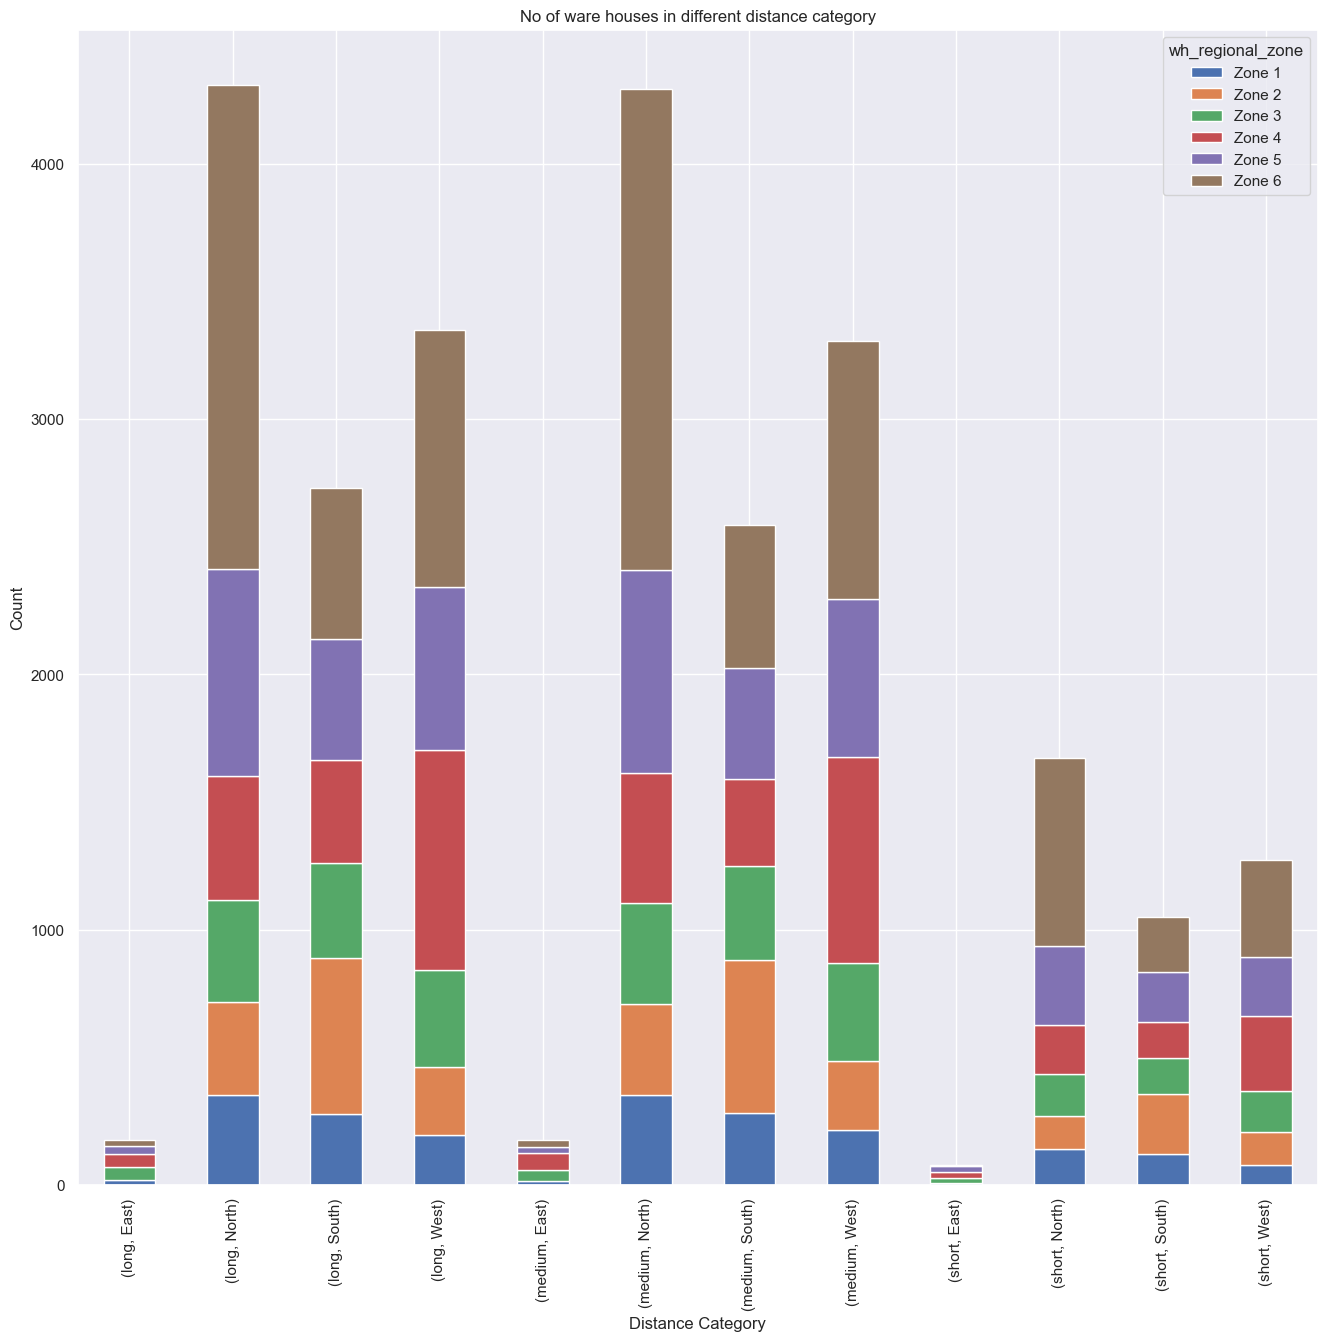

In [71]:
grouped_data = fmcg_data.groupby(["Distance Category", "wh_regional_zone", "zone"])["wh_regional_zone"].count().unstack("wh_regional_zone")
grouped_data.plot(kind='bar', stacked=True)

# Add axis labels and a title
plt.xlabel("Distance Category")
plt.ylabel('Count')
plt.title('No of ware houses in different distance category')

# Show the plot
plt.show()

In [72]:
grouped_data

wh_regional_zone         Zone 1  Zone 2  Zone 3  Zone 4  Zone 5  Zone 6
Distance Category zone                                                 
long              East     20.0     NaN    51.0    50.0    30.0    25.0
                  North   351.0   366.0   401.0   485.0   811.0  1897.0
                  South   278.0   610.0   374.0   401.0   476.0   590.0
                  West    196.0   266.0   380.0   862.0   639.0  1008.0
medium            East     14.0     NaN    43.0    67.0    24.0    26.0
                  North   351.0   357.0   395.0   510.0   795.0  1886.0
                  South   283.0   599.0   367.0   341.0   436.0   558.0
                  West    215.0   272.0   383.0   808.0   619.0  1010.0
short             East      9.0     NaN    18.0    25.0    20.0     7.0
                  North   139.0   131.0   165.0   191.0   311.0   736.0
                  South   119.0   235.0   144.0   140.0   195.0   216.0
                  West     79.0   127.0   160.0   296.0   231.0   380.0

Shipping costs: The farther the distance, the higher the shipping costs. This can be a significant factor in determining the overall profitability of a product.

Delivery time: Shipping times increase with distance, which may more likely lead to less or no supply if the refill is not done in proper time. This can impact customer satisfaction and repeat business.

Supply chain complexity: Longer distances may require more complex supply chain management, including more warehouses and transportation networks, which can increase operational costs.

The distance and number of refills required to supply a warehouse will depend on a few factors, including the size of the warehouse and the frequency of deliveries.

The type of inventory being stored may also impact the frequency and volume of deliveries. For example, warehouses that store perishable goods may require more frequent deliveries to ensure that inventory stays fresh.

when the demand and WH size is more like in case of Zone 6 North, and the distance is number, frequent shipping can be minimised to optimize the transportation costs and inventory management. This may involve working with logistics providers to develop efficient delivery schedules, implementing inventory tracking systems to better manage stock levels.

Overall, the distance and number of refills required to supply a warehouse will vary depending on a range of factors, and it's important to develop a customized supply chain strategy to meet the specific needs of the business.

## Data Distribution

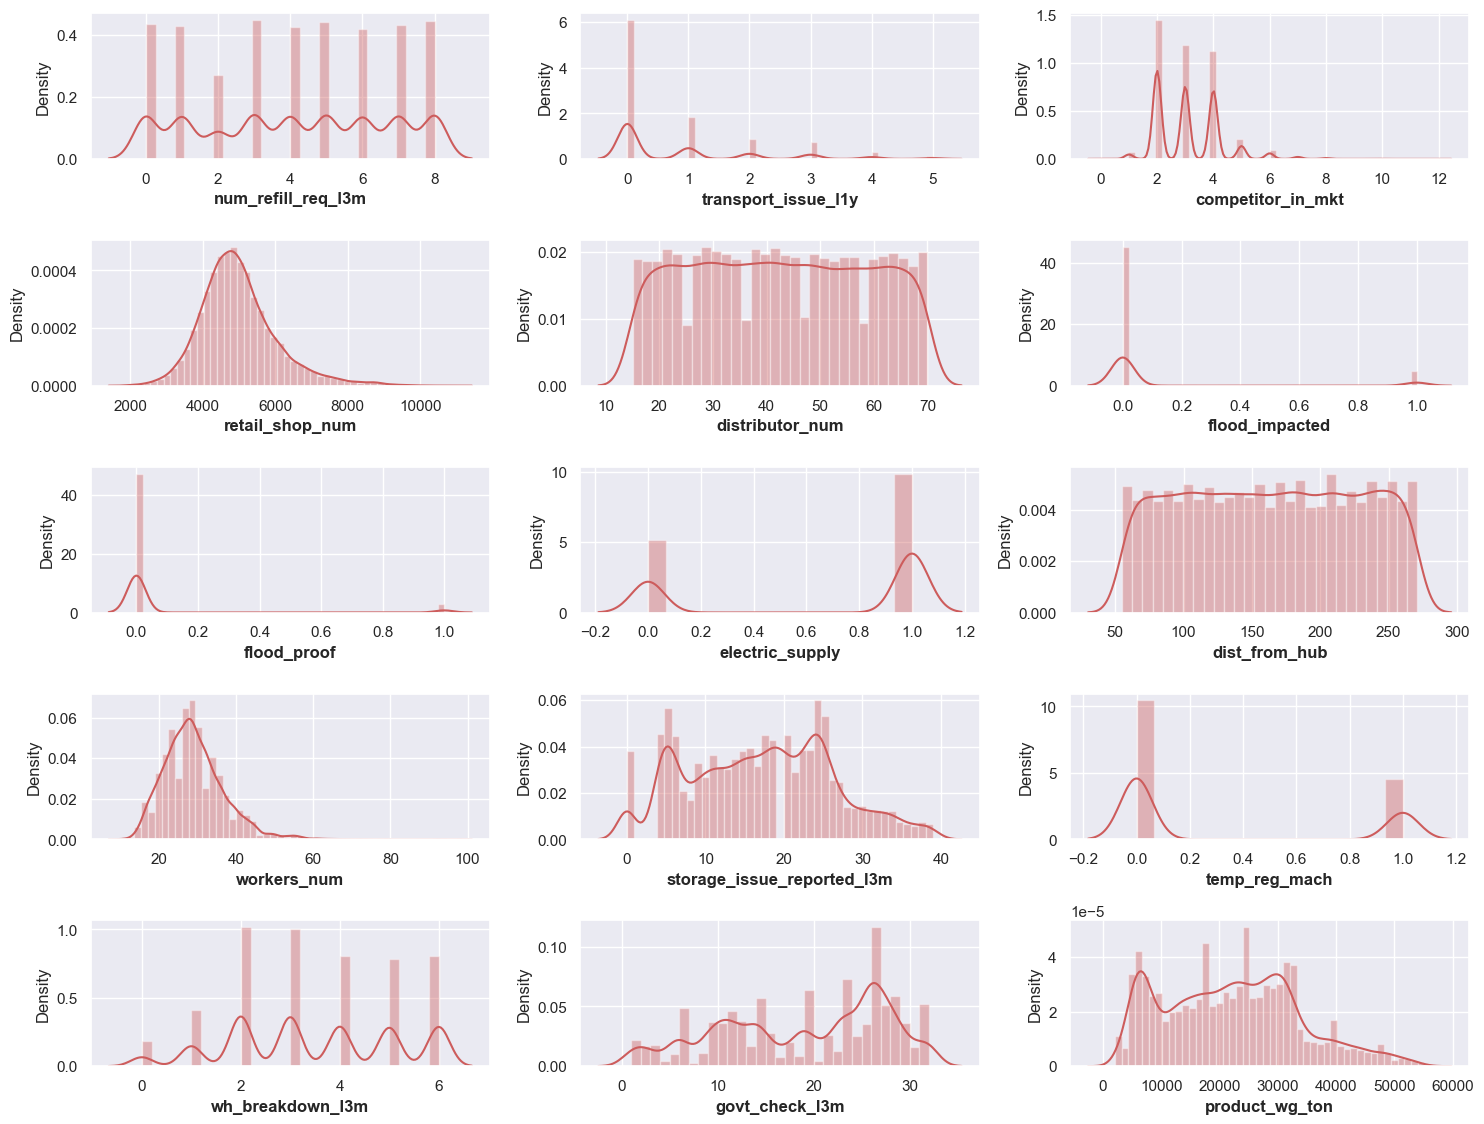

In [73]:
numeric_features = [feature for feature in fmcg_data.columns if fmcg_data[feature].dtype != 'O']

plt.figure(figsize=(15, 20))
for i, col in enumerate(numeric_features):
    plt.subplot(9, 3, i+1)
    sns.distplot(x=fmcg_data[col], color='indianred')
    plt.xlabel(col, weight='bold')
    plt.tight_layout()

In [74]:
# plt.figure(figsize=(15, 20))
# for i, col in enumerate(numeric_features):
#     plt.subplot(9, 3, i+1)
#     sns.boxplot(x=fmcg_data[col], color='indianred')
#     plt.xlabel(col, weight='bold')
#     plt.tight_layout()

### Data imputation and transformation

### Categorical data Mapping

In [75]:
fmcg_data["location_type"] = fmcg_data["location_type"].map({"Urban":0, "Rural":1})
fmcg_data["wh_capacity_size"]=fmcg_data["wh_capacity_size"].map({"Small":0, "Mid":1, "Large":2})
fmcg_data["wh_owner_type"]=fmcg_data["wh_owner_type"].map({"Rented":0, "Company Owned":1})

In [76]:
first_look(fmcg_data, "approved_wh_govt_certificate")

column name    :  approved_wh_govt_certificate
per_of_nulls   :  % 3.63
num_of_nulls   :  908
num_of_uniques :  5
Value counts   : 
 C      5501
B+     4917
B      4812
A      4671
A+     4191
NaN     908
Name: approved_wh_govt_certificate, dtype: int64
----------------------------------------------------------------------------------------------------


### Encoding

In [77]:
fmcg_data["approved_wh_govt_certificate"]=fmcg_data["approved_wh_govt_certificate"].map({"C":0, "B":1, "B+":2, "A":3,"A+":4})

In [78]:
fmcg_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25000 entries, 0 to 24999
Data columns (total 24 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   ware_house_id                 25000 non-null  object 
 1   wh_manager_id                 25000 non-null  object 
 2   location_type                 25000 non-null  int64  
 3   wh_capacity_size              25000 non-null  int64  
 4   zone                          25000 non-null  object 
 5   wh_regional_zone              25000 non-null  object 
 6   num_refill_req_l3m            25000 non-null  int64  
 7   transport_issue_l1y           25000 non-null  int64  
 8   competitor_in_mkt             25000 non-null  int64  
 9   retail_shop_num               25000 non-null  int64  
 10  wh_owner_type                 25000 non-null  int64  
 11  distributor_num               25000 non-null  int64  
 12  flood_impacted                25000 non-null  int64  
 13  f

In [79]:
categorical_cols = fmcg_data.select_dtypes(include="object")
categorical_cols=categorical_cols.columns.values
req_cat_cols=categorical_cols[2:-1]
req_cat_cols

array(['zone', 'wh_regional_zone'], dtype=object)

In [80]:
fmcg_data = pd.get_dummies(fmcg_data, columns=req_cat_cols, drop_first=True)

In [81]:
drop_cols = ["ware_house_id", "wh_manager_id","Distance Category"]

In [82]:
df=fmcg_data.drop(columns=drop_cols)

In [83]:
from sklearn.impute import KNNImputer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import RobustScaler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import  train_test_split, cross_val_score

## KNN Imputer for Null values

### Why KNN Imputer?
- KNNImputer by scikit-learn is a widely used method to impute missing values. It is widely being observed as a replacement for traditional imputation techniques.

- KNNImputer helps to impute missing values present in the observations by finding the nearest neighbors with the distance matrix.

- Here we Iterates through different K values and get accuracy and choose best K values.

In [84]:
X = df.drop(columns="product_wg_ton", axis=1)
y = df["product_wg_ton"]

In [85]:
from sklearn.impute import KNNImputer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import  train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV

In [86]:
X_train, X_test, y_train, y_test=train_test_split(X,y,test_size=0.33, random_state=42)

### Robust Scaling

In [87]:
robust_scalar = RobustScaler()
X1 = robust_scalar.fit_transform(X_train)

In [88]:
# from sklearn.model_selection import GridSearchCV
# # Create pipeline with KNN imputer and random forest regressor
# pipeline = Pipeline([
#     ('imputer', KNNImputer()),
#     ('regressor', RandomForestRegressor())
# ])
# # Define parameter grid for KNN imputer
# param_grid = {
#     'imputer__n_neighbors': [3, 5, 7],
#     'imputer__weights': ['distance']
# }
# # Perform grid search with pipeline and parameter grid
# grid_search = GridSearchCV(pipeline, param_grid=param_grid, cv=2)

# # Fit grid search on dataset
# grid_search.fit(X1, y_train)
# # Print best hyperparameters and score
# print(f"Best hyperparameters: {grid_search.best_params_}")
# print(f"Best score: {grid_search.best_score_}")

### Pipeline for KNN imputer

In [89]:
pipeline = Pipeline(steps=[("robust_scalar" , RobustScaler()),("imputer" , KNNImputer(n_neighbors=5, weights='distance'))])
pipeline.fit(X_train)
# Transform numerical data to fill in missing values
x_imputed  = pipeline.transform(X_train)
x_imputed = pd.DataFrame(x_imputed, columns=X_train.columns)

### Feature Selection

In [90]:
multicolinearity_control(X)

No Multicolinearity


In [91]:
X_vif=x_imputed.copy()

### Variance Inflation Factor  

In [92]:
from statsmodels.stats.outliers_influence import variance_inflation_factor as vif
from statsmodels.formula.api import ols

In [93]:
X_vif["intercept"]=1

In [94]:
def VIF(df):
    x=1
    while x:
        VIF = pd.DataFrame()
        VIF['Independent_Variables'] = df.columns
        VIF['VIF'] = [vif(df.values, i) for i in range(df.shape[1])]
        VIF = VIF.set_index('Independent_Variables').drop(index = 'intercept').T
        for i, value in enumerate(VIF.values[0]):
            if value>5:
                x=1
                df.drop(columns=VIF.columns[i], axis=1, inplace=True)
                break
            else:
                x=0
    return VIF

In [95]:
VIF(X_vif)

Independent_Variables,location_type,wh_capacity_size,num_refill_req_l3m,transport_issue_l1y,competitor_in_mkt,retail_shop_num,wh_owner_type,distributor_num,flood_impacted,flood_proof,electric_supply,dist_from_hub,workers_num,storage_issue_reported_l3m,temp_reg_mach,approved_wh_govt_certificate,wh_breakdown_l3m,govt_check_l3m,zone_South,zone_West,wh_regional_zone_Zone 2,wh_regional_zone_Zone 3,wh_regional_zone_Zone 4,wh_regional_zone_Zone 6
VIF,1.008281,1.149639,1.084062,1.031541,1.193066,1.045169,1.076052,1.00114,1.057953,1.020555,1.196724,1.001191,1.171065,1.221985,1.175903,1.115809,1.173731,1.194968,1.356206,1.355099,1.329416,1.358199,1.492255,1.524726


In [96]:
X_vif.drop(columns="intercept", inplace=True)
X_vif

,location_type,wh_capacity_size,num_refill_req_l3m,transport_issue_l1y,competitor_in_mkt,retail_shop_num,wh_owner_type,distributor_num,flood_impacted,flood_proof,electric_supply,dist_from_hub,workers_num,storage_issue_reported_l3m,temp_reg_mach,approved_wh_govt_certificate,wh_breakdown_l3m,govt_check_l3m,zone_South,zone_West,wh_regional_zone_Zone 2,wh_regional_zone_Zone 3,wh_regional_zone_Zone 4,wh_regional_zone_Zone 6
0,-1.0,0.0,-0.25,0.0,0.0,0.877126,-1.0,0.148148,0.0,0.0,-1.0,0.546296,1.111111,0.428571,1.0,1.0,-0.333333,0.333333,1.0,0.0,0.0,0.0,1.0,0.0
1,0.0,-1.0,1.00,0.0,-0.5,0.531037,-1.0,-0.925926,0.0,0.0,-1.0,-0.129630,0.469097,-0.928571,0.0,0.5,0.333333,-0.800000,0.0,0.0,0.0,0.0,0.0,1.0
2,0.0,1.0,1.00,0.0,0.5,2.479167,0.0,-0.740741,0.0,0.0,0.0,0.425926,-0.111111,0.142857,0.0,0.0,1.000000,-1.000000,0.0,1.0,0.0,0.0,0.0,1.0
3,0.0,1.0,0.50,3.0,0.0,-0.147534,0.0,-0.888889,1.0,0.0,0.0,0.296296,0.222222,-0.214286,0.0,0.0,1.000000,0.200000,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.25,0.0,0.5,-0.142432,-1.0,-0.703704,0.0,0.0,0.0,0.138889,0.333333,-0.928571,1.0,0.5,-0.333333,0.333333,0.0,1.0,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16745,0.0,0.0,0.50,0.0,0.5,-0.422194,0.0,0.259259,0.0,0.0,0.0,-1.000000,-0.333333,0.071429,0.0,0.5,-0.666667,-0.133333,0.0,1.0,0.0,1.0,0.0,0.0
16746,0.0,1.0,-1.00,1.0,0.5,1.806548,0.0,-0.703704,0.0,0.0,0.0,0.592593,-0.222222,-0.142857,0.0,1.0,0.000000,-0.466667,0.0,0.0,0.0,0.0,0.0,0.0
16747,-1.0,0.0,0.75,1.0,0.0,-0.034439,-1.0,-0.740741,0.0,0.0,-1.0,0.212963,-0.444444,0.142857,0.0,-1.0,-0.333333,0.333333,0.0,0.0,0.0,0.0,1.0,0.0
16748,0.0,0.0,-0.75,0.0,-0.5,0.042942,0.0,0.740741,0.0,0.0,0.0,0.583333,-0.222222,0.071429,0.0,-0.5,-0.333333,0.400000,0.0,0.0,0.0,1.0,0.0,0.0


### OLS method for feature selection

In [97]:
# def ols_method(df, final_df):
#     ft=' + '.join(df)
#     formula = "product_wg_ton ~ "+ft
#     lm_fit_multi = ols(formula, data = final_df).fit()
#     return lm_fit_multi.summary()
# ols_method(df_vif, final_df)

### Ensemble techinque to select the most important features

In [98]:
# from sklearn.tree import DecisionTreeRegressor
# from sklearn.ensemble import RandomForestRegressor
# import pandas as pd



# # create Random Forest classifier
# rf = RandomForestRegressor()

# # fit the model on the data
# rf.fit(imp_feat, y_train)

# # get feature importances
# importances = rf.feature_importances_

# # create a dataframe to display feature importances
# feature_importances = pd.DataFrame({'feature': imp_feat.columns, 'importance': importances})
# feature_importances = feature_importances.sort_values(by='importance', ascending=False).reset_index(drop=True)

# # print the feature importances
# print(feature_importances)
# import matplotlib.pyplot as plt

# # plot feature importances in descending order
# plt.figure(figsize=(10, 6))
# plt.bar(feature_importances['feature'], feature_importances['importance'])
# plt.xticks(rotation=90)
# plt.xlabel('Feature')
# plt.ylabel('Importance')
# plt.title('Feature Importances')
# plt.show()

We cannot delete the features ware house region and zone columns obtained from result of VIF

### Lasso regularization for feature selection

In [99]:
x_imputed_test  = pipeline.transform(X_test)
x_imputed_test = pd.DataFrame(x_imputed_test, columns=X_test.columns)

In [100]:
from sklearn.linear_model import Lasso
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.metrics import r2_score


# Fit Lasso regression model with alpha=0.1
lasso = Lasso(alpha=0.01)
lasso.fit(x_imputed, y_train)

# Print the selected features based on the non-zero coefficients
print("Lasso selected features:", x_imputed.columns[lasso.coef_ != 0])

# Evaluate the model on the test set
y_pred = lasso.predict(x_imputed_test)
print("Lasso R2 score:", r2_score(y_test, y_pred))

Lasso selected features: Index(['location_type', 'wh_capacity_size', 'num_refill_req_l3m',
       'transport_issue_l1y', 'competitor_in_mkt', 'retail_shop_num',
       'wh_owner_type', 'distributor_num', 'flood_impacted', 'flood_proof',
       'electric_supply', 'dist_from_hub', 'workers_num',
       'storage_issue_reported_l3m', 'temp_reg_mach',
       'approved_wh_govt_certificate', 'wh_breakdown_l3m', 'govt_check_l3m',
       'zone_North', 'zone_South', 'zone_West', 'wh_regional_zone_Zone 2',
       'wh_regional_zone_Zone 3', 'wh_regional_zone_Zone 4',
       'wh_regional_zone_Zone 5', 'wh_regional_zone_Zone 6'],
      dtype='object')
Lasso R2 score: 0.9766896638500405


### Model Building and Evaluation

In [101]:
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from sklearn.metrics import r2_score, mean_squared_error

In [102]:
# !pip install xgboost

### Initialize Default Models in a dictionary

In [103]:
# Dictionary which contains models for experiment
models = {
    "Linear Regression": LinearRegression(),
    "Random Forest": RandomForestRegressor(),
    "Gradient Boosting": GradientBoostingRegressor(), 
}

In [104]:
def evaluate_reg(true, predicted):
    rmse = mean_squared_error(true, predicted, squared=False)
    r_score = r2_score(true, predicted)
    return rmse, r_score

In [105]:
def evaluate_models(X_train, y_train, X_test, y_test, models):
    
    models_list = {}
    
    for i in range(len(list(models))):
        model = list(models.values())[i]
        model.fit(X_train, y_train) # Train model
        # Make predictions
        y_train_pred = model.predict(X_train)
        y_test_pred = model.predict(X_test)
      
        # Train set performance
        model_train_rmse, model_train_r2_score =evaluate_reg(y_train, y_train_pred)
        
        # Test set performance
        model_test_rmse, model_test_r2_score =evaluate_reg(y_test, y_test_pred)
        
        model_ = list(models.keys())[i]

        print(list(models.keys())[i])
        # models_list.append(list(models.keys())[i])

        print('Model performance for Training  set')
        print('- rmse: {:.4f}'.format(model_train_rmse))
        print('- r2 score: {:.4f}'.format(model_train_r2_score))
        
        print('----------------------------------')
        
        print('Model performance for Test set')
        print('- rmse: {:.4f}'.format(model_test_rmse))
        print('- r2 score: {:.4f}'.format(model_test_r2_score))
        
 
        print('\n')
    return pd.DataFrame({'original test set':y_test, 'predictions': y_test_pred}).head()

### Model result and predictions

In [106]:
evaluate_models(x_imputed,y_train,x_imputed_test,y_test, models )

Linear Regression
Model performance for Training  set
- rmse: 1716.6260
- r2 score: 0.9781
----------------------------------
Model performance for Test set
- rmse: 1771.9822
- r2 score: 0.9767


Random Forest
Model performance for Training  set
- rmse: 361.3957
- r2 score: 0.9990
----------------------------------
Model performance for Test set
- rmse: 969.4810
- r2 score: 0.9930


Gradient Boosting
Model performance for Training  set
- rmse: 915.8558
- r2 score: 0.9938
----------------------------------
Model performance for Test set
- rmse: 947.6589
- r2 score: 0.9933




,original test set,predictions
6868,6058,6613.233797
24016,17073,17077.843166
9668,11101,11033.616302
13640,31095,29459.140212
14018,17134,18739.825254


In [107]:
cv_x_imputed = x_imputed.to_numpy()
cv_y_train = y_train.to_numpy()

### Cross validation

In [108]:
import numpy as np

kfold = KFold(n_splits=5, shuffle=True, random_state=42)
scores = []
for train_index, test_index in kfold.split(cv_x_imputed):
    # Split the data into training and testing sets for this fold
    X_fold_train, X_fold_test = cv_x_imputed[train_index], cv_x_imputed[test_index]
    y_fold_train, y_fold_test = cv_y_train[train_index], cv_y_train[test_index]
    
    # Train the model on the training data for this fold
    model = GradientBoostingRegressor()
    model.fit(X_fold_train, y_fold_train)
    
    # Evaluate the performance on the testing data for this fold
    y_fold_pred = model.predict(X_fold_test)
    fol_score = r2_score(y_fold_test, y_fold_pred)
    scores.append(fol_score)

print("Average Score:", np.mean(scores))

Average Score: 0.9935441292311153


#### Gradient Boosting is giving more accuracy and less error when compared to other model

### Gradient Boosting is the best model to predict the optimum weight of the product to be shipped to the warehouse